In [8]:
# from langchain.tools import tool
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START, END
# from langgraph.graph import MessagesState  # 사용하지 않음: Cell 3에서 직접 정의
from langchain.messages import AnyMessage
from typing_extensions import TypedDict, Annotated
import operator
from langchain.messages import SystemMessage
# from langchain.messages import ToolMessage
from typing import List
# from typing import Literal  # 사용하지 않음

from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings
from langchain_core.vectorstores import InMemoryVectorStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from langchain.messages import HumanMessage, AIMessage
# from langchain_core.retrievers import BaseRetriever  # 사용하지 않음

c:\Users\jw160\project\RAG\.venv\Lib\site-packages\langchain_core\_api\deprecation.py:26: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.fields import FieldInfo as FieldInfoV1


In [9]:
# 샘플 문서 데이터
documents = [
    "인공지능(AI)은 컴퓨터 시스템이 인간의 지능을 모방하여 학습하고 추론할 수 있도록 하는 기술입니다.",
    "머신러닝은 AI의 한 분야로, 데이터로부터 패턴을 학습하여 예측이나 분류를 수행합니다.",
    "딥러닝은 신경망을 사용하여 복잡한 패턴을 학습하는 머신러닝의 하위 분야입니다.",
    "자연어처리(NLP)는 인간의 언어를 컴퓨터가 이해하고 처리할 수 있도록 하는 AI 기술입니다.",
    "컴퓨터 비전은 이미지나 비디오에서 의미 있는 정보를 추출하는 AI 분야입니다."
]

# Document 객체로 변환
docs = [Document(page_content=text) for text in documents]

# 텍스트 분할
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,
    chunk_overlap=50
)
splits = text_splitter.split_documents(docs)

In [10]:
embeddings = HuggingFaceEndpointEmbeddings(client="http://127.0.0.1:8080/")
vectorstore = InMemoryVectorStore.from_documents(splits, embeddings)

In [11]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int
    intent: str  # 의도 분류 결과를 저장하기 위해 추가
    retrieved_docs: List[Document]  # 선택사항: 검색된 문서 저장
    retrieval_attempts: int  # 재검색 시도 횟수

In [12]:
model = init_chat_model(
    "smollm2",
    model_provider="ollama",
    base_url="http://localhost:11434",
    temperature=0,
    max_tokens=50,
    model_kwargs={
    "num_predict": 50  # Ollama 전용 파라미터
    }
)


In [ ]:
def intent_classifier(state: dict):
    """사용자 메시지에서 의도를 분류"""
    # dict 또는 Message 객체 모두 처리
    last_message = state["messages"][-1] if state["messages"] else None
    if last_message:
        if isinstance(last_message, dict):
            user_message = last_message.get("content", "")
        else:
            user_message = last_message.content
    else:
        user_message = ""
    
    response = model.invoke(
        [
            SystemMessage(
                content="""당신은 의도 분류 전문가입니다. 주어진 문장의 의도를 다음 중 하나로 분류하세요:
- 정보요청: 특정 주제에 대한 정보나 설명을 요청
- 개념정의: 용어나 개념의 정의를 요청
- 비교분석: 두 가지 이상의 개념을 비교하거나 관계를 파악
- 기술질문: 작동 방식이나 방법론에 대한 질문
- 기타: 위에 해당하지 않는 경우

의도만 답변하세요. 예: "정보요청" """
            ),
            HumanMessage(content=f"문장: {user_message}")
        ]
    )
    
    return {
        "messages": [response],  # 새 메시지만 반환 (operator.add가 자동 합침)
        "intent": response.content.strip(),
        "llm_calls": state.get('llm_calls', 0) + 1
    }

def retriever_call(state: dict):
    """의도에 따라 적절한 검색 수행"""
    retrieval_attempts = state.get("retrieval_attempts", 0)
    
    # 재시도 시 검색 개수 증가
    k = 5 + (retrieval_attempts * 3)  # 재시도할 때마다 더 많이 검색
    
    retriever = vectorstore.as_retriever(
        search_type="similarity",
        search_kwargs={"k": min(k, 10)}  # 최대 10개
    )
    
    # 사용자 메시지에서 검색어 추출 (dict 또는 Message 객체 처리)
    first_message = state["messages"][0] if state["messages"] else None
    if first_message:
        if isinstance(first_message, dict):
            user_message = first_message.get("content", "")
        else:
            user_message = first_message.content
    else:
        user_message = ""
    
    docs = retriever.invoke(user_message)
    
    return {
        "messages": [],
        "retrieved_docs": docs,
        "user_query": user_message
    }

def verify_retrieval(state: dict):
    """검색 결과 관련성 검증"""
    user_query = state.get("user_query", "")
    intent = state.get("intent", "")
    retrieved_docs = state.get("retrieved_docs", [])
    retrieval_attempts = state.get("retrieval_attempts", 0)
    
    if not retrieved_docs:
        return {
            "messages": [],
            "retrieval_valid": False,
            "filtered_docs": [],
            "retrieval_attempts": retrieval_attempts + 1
        }
    
    # LLM으로 관련성 검증
    doc_summaries = "\n".join([f"{i+1}. {doc.page_content[:100]}..." for i, doc in enumerate(retrieved_docs)])
    
    verification = model.invoke([
        SystemMessage(content="""검색된 문서들이 사용자 질문과 의도에 관련이 있는지 판단하세요.
'관련있음' 또는 '관련없음' 중 하나만 답변하세요."""),
        HumanMessage(content=f"""사용자 질문: {user_query}
의도: {intent}

검색된 문서:
{doc_summaries}

관련성이 있는 문서 번호만 쉼표로 구분하여 나열하세요. 예: 1,3,5""")
    ])
    
    # 관련 문서 필터링
    try:
        relevant_indices = [int(x.strip()) - 1 for x in verification.content.split(",")]
        filtered_docs = [retrieved_docs[i] for i in relevant_indices if 0 <= i < len(retrieved_docs)]
    except:
        # 파싱 실패 시 모든 문서 사용
        filtered_docs = retrieved_docs
    
    if not filtered_docs:
        return {
            "messages": [],
            "retrieval_valid": False,
            "filtered_docs": [],
            "retrieval_attempts": retrieval_attempts + 1
        }
    
    return {
        "messages": [SystemMessage(content=f"참고 문서:\n{chr(10).join([d.page_content for d in filtered_docs])}")],
        "retrieval_valid": True,
        "filtered_docs": filtered_docs,
        "retrieval_attempts": retrieval_attempts
    }

def should_retry_retrieval(state: dict) -> str:
    """검색 재시도 여부 결정"""
    retrieval_valid = state.get("retrieval_valid", False)
    retrieval_attempts = state.get("retrieval_attempts", 0)
    max_attempts = 2  # 최대 2번까지 재시도
    
    if retrieval_valid:
        return "proceed_to_llm"  # 검증 성공 -> LLM 호출
    elif retrieval_attempts < max_attempts:
        return "retry_retrieval"  # 재시도 가능 -> 다시 검색
    else:
        return "proceed_without_docs"  # 최대 시도 초과 -> 문서 없이 진행

def llm_call(state: dict):
    """의도에 맞는 응답 생성"""
    # 사용자 메시지 추출 (dict 또는 Message 객체 처리)
    first_message = state["messages"][0] if state["messages"] else None
    if first_message:
        if isinstance(first_message, dict):
            user_message = first_message.get("content", "")
        else:
            user_message = first_message.content
    else:
        user_message = ""
    
    intent = state.get("intent", "정보요청")
    
    intent_prompts = {
        "정보요청": "사용자가 요청한 정보를 참고 문서를 바탕으로 자세히 설명해주세요.",
        "개념정의": "참고 문서를 바탕으로 요청한 개념의 정의를 명확하게 설명해주세요.",
        "비교분석": "참고 문서를 바탕으로 요청한 개념들의 차이점과 관계를 비교하여 설명해주세요.",
        "기술질문": "참고 문서를 바탕으로 작동 방식이나 방법론을 설명해주세요.",
        "기타": "참고 문서를 바탕으로 사용자의 질문에 답변해주세요."
    }
    
    # 현재 state의 messages를 사용 (이미 모든 이전 메시지 포함)
    response = model.invoke(
        state["messages"] + [
            SystemMessage(content=intent_prompts.get(intent, intent_prompts["기타"]))
        ]
    )
    
    return {
        "messages": [response],  # 새 메시지만 반환 (operator.add가 자동 합침)
        "llm_calls": state.get('llm_calls', 0) + 1
    }

def llm_call_without_docs(state: dict):
    """문서 없이 일반 응답 생성"""
    first_message = state["messages"][0] if state["messages"] else None
    if first_message:
        if isinstance(first_message, dict):
            user_message = first_message.get("content", "")
        else:
            user_message = first_message.content
    else:
        user_message = ""
    
    response = model.invoke(
        state["messages"] + [
            SystemMessage(content="관련 문서를 찾을 수 없어 일반적인 지식으로 답변합니다. 사용자의 질문에 최선을 다해 답변해주세요.")
        ]
    )
    
    return {
        "messages": [response],
        "llm_calls": state.get('llm_calls', 0) + 1
    }

In [14]:
#  content="당신은 감정 분석 전문가입니다. 문장의 감정을 분석하여 반드시 '긍정' 또는 '부정' 중 하나만 답변하세요. 추가 설명 없이 감정만 판단하세요"
# content="당신은 키워드 추출 전문가입니다. 주어진 문장에서 핵심 키워드만 뽑아 한글 쉼표(,)로 구분하여 나열하세요. 불필요한 설명 없이 키워드만 답변하세요."

In [15]:
# 의도 파악 -> 검색 -> 응답 

In [18]:
graph = StateGraph(MessagesState)

# 모든 노드 추가
graph.add_node("intent_classifier", intent_classifier)
graph.add_node("retriever_call", retriever_call)
graph.add_node("verify_retrieval", verify_retrieval)
graph.add_node("llm_call", llm_call)
graph.add_node("llm_call_without_docs", llm_call_without_docs)

# 일반 엣지 추가
graph.add_edge(START, "intent_classifier")
graph.add_edge("intent_classifier", "retriever_call")
graph.add_edge("retriever_call", "verify_retrieval")

# 조건부 분기: 검증 결과에 따라 분기
graph.add_conditional_edges(
    "verify_retrieval",
    should_retry_retrieval,
    {
        "proceed_to_llm": "llm_call",  # 검증 성공 -> LLM 호출
        "retry_retrieval": "retriever_call",  # 재시도 -> 다시 검색
        "proceed_without_docs": "llm_call_without_docs"  # 최대 시도 초과 -> 문서 없이 응답
    }
)

# 종료 엣지
graph.add_edge("llm_call", END)
graph.add_edge("llm_call_without_docs", END)

# 마지막에 compile
graph = graph.compile()

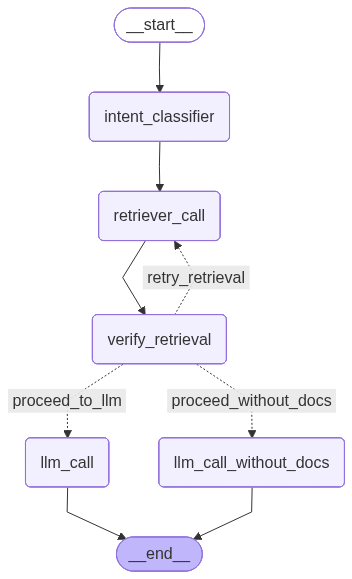

In [19]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [20]:
graph.invoke({"messages": [{"role": "user", "content": "컴퓨터 비전에 대해 알려줘"}]})

{'messages': [{'role': 'user', 'content': '컴퓨터 비전에 대해 알려줘'},
  AIMessage(content='개념정의: 컴퓨터 비전', additional_kwargs={}, response_metadata={'model': 'smollm2', 'created_at': '2025-12-08T13:35:39.809227746Z', 'done': True, 'done_reason': 'stop', 'total_duration': 30553623526, 'load_duration': 3001199447, 'prompt_eval_count': 454, 'prompt_eval_duration': 18336938343, 'eval_count': 28, 'eval_duration': 9178602657, 'logprobs': None, 'model_name': 'smollm2', 'model_provider': 'ollama'}, id='lc_run--576a8127-20b4-4ffc-8d55-4e36ec1dfaef-0', usage_metadata={'input_tokens': 454, 'output_tokens': 28, 'total_tokens': 482}),
  SystemMessage(content='참고 문서:\n딥러닝은 신경망을 사용하여 복잡한 패턴을 학습하는 머신러닝의 하위 분야입니다.\n인공지능(AI)은 컴퓨터 시스템이 인간의 지능을 모방하여 학습하고 추론할 수 있도록 하는 기술입니다.\n컴퓨터 비전은 이미지나 비디오에서 의미 있는 정보를 추출하는 AI 분야입니다.\n머신러닝은 AI의 한 분야로, 데이터로부터 패턴을 학습하여 예측이나 분류를 수행합니다.\n자연어처리(NLP)는 인간의 언어를 컴퓨터가 이해하고 처리할 수 있도록 하는 AI 기술입니다.', additional_kwargs={}, response_metadata={}),
  AIMessage(content='저는 컴퓨터 비전, 인공지능, 자연어처리, 데이터 분

In [21]:
graph.invoke({"messages": [{"role": "user", "content": "오늘 날씨가 좋아요."}]})

KeyboardInterrupt: 

In [12]:
# 키워드 추출, 감정 분석, 코딩 등 활용 고려